# ***Import Libarys***

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet import ResNet101
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetV2L

import random
import os
import warnings
warnings.filterwarnings('ignore')
print('compelet')

compelet


# ***Data understanding & Visualizatio***

In [6]:
image_shape = (224,224)
batch_size = 64

train_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

# apply scaling only becouse data already augmented
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# load training data
print("Training Images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')

# load validation data (20% of training data)
print("Validating Images:")
valid_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

# load test data (consider validation data as test data)
print('Test Images:')
test_data = test_datagen.flow_from_directory(valid_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)


Training Images:
Found 56251 images belonging to 38 classes.
Validating Images:
Found 14044 images belonging to 38 classes.
Test Images:
Found 17572 images belonging to 38 classes.


***From previous cell we know that we have 38 class***
> * 56251 images in train data
> * 14044 images in valisation data
> * 17572 images in test data
> * 33 imgeas in test data (the label of test data is the name of image) we will uses them to predict later

***But what are 38 classes ?!***

In [5]:
# show how data store 
images, labels = next(iter(train_data))
print(f'shape of image is : {images[0].shape}')
print(f'label  \n{labels[0]}')

shape of image is : (224, 224, 3)
label  
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
# show all diseases in dataset
diseases = os.listdir(train_dir)
print(diseases)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

***We notice that we have the same plant in different class such as:***
 > * Tomato___Early_blight
 > * Tomato___Late_blight
 > * Tomato___healthy
 > * ...

***so we need to know what is the different type of plant we have***

In [7]:
# identify uniqe plant in dataset
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
print(f'number of different plants is :{len(plants)}')
print(plants)

number of different plants is :14
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


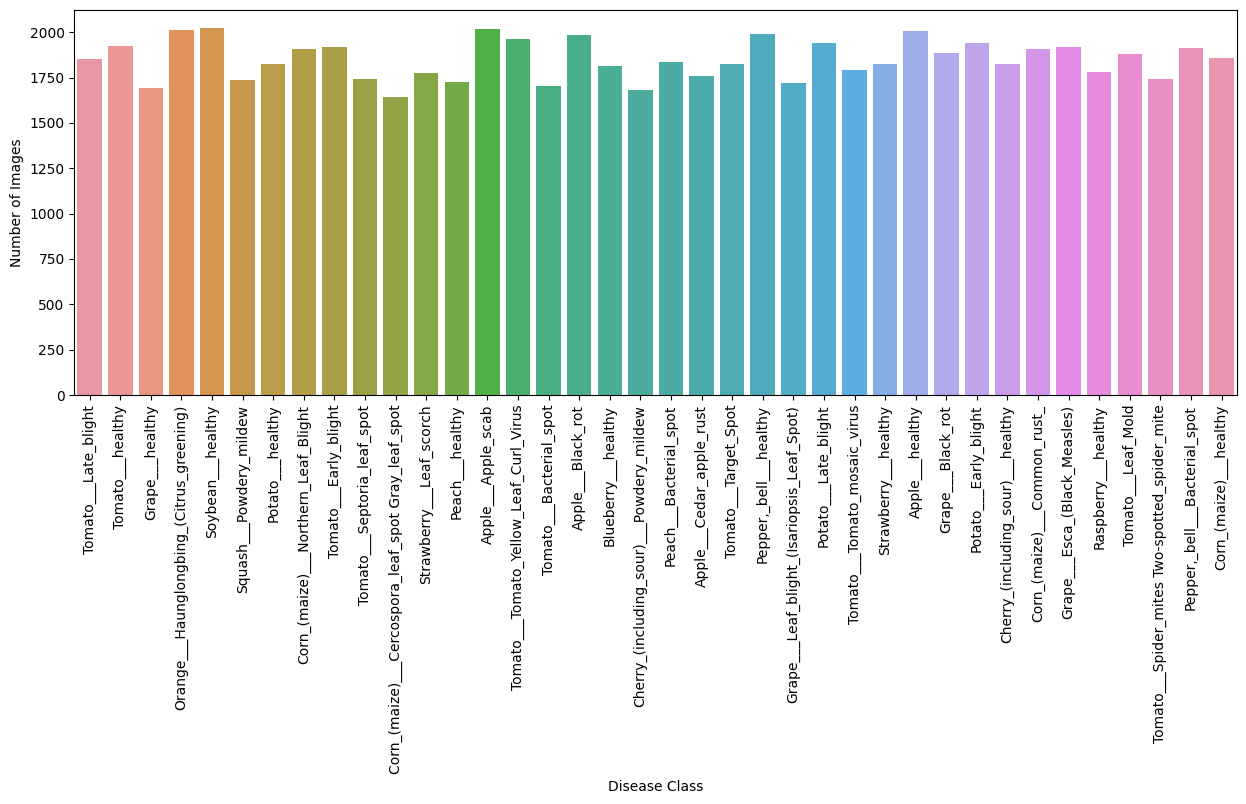

In [8]:
# show number of each class
dic = {}
for Class in diseases:
    dic[Class] = len(os.listdir(train_dir + '/' + Class))

df = pd.DataFrame(list(dic.items()), columns=["Disease Class", "Number of Images"])

# df = df.sort_values(by="Number of Images", ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=df ,x='Disease Class' ,y= 'Number of Images' )
plt.xticks(rotation=90)
plt.show()

***As we notice that classes are somewhat balanced***

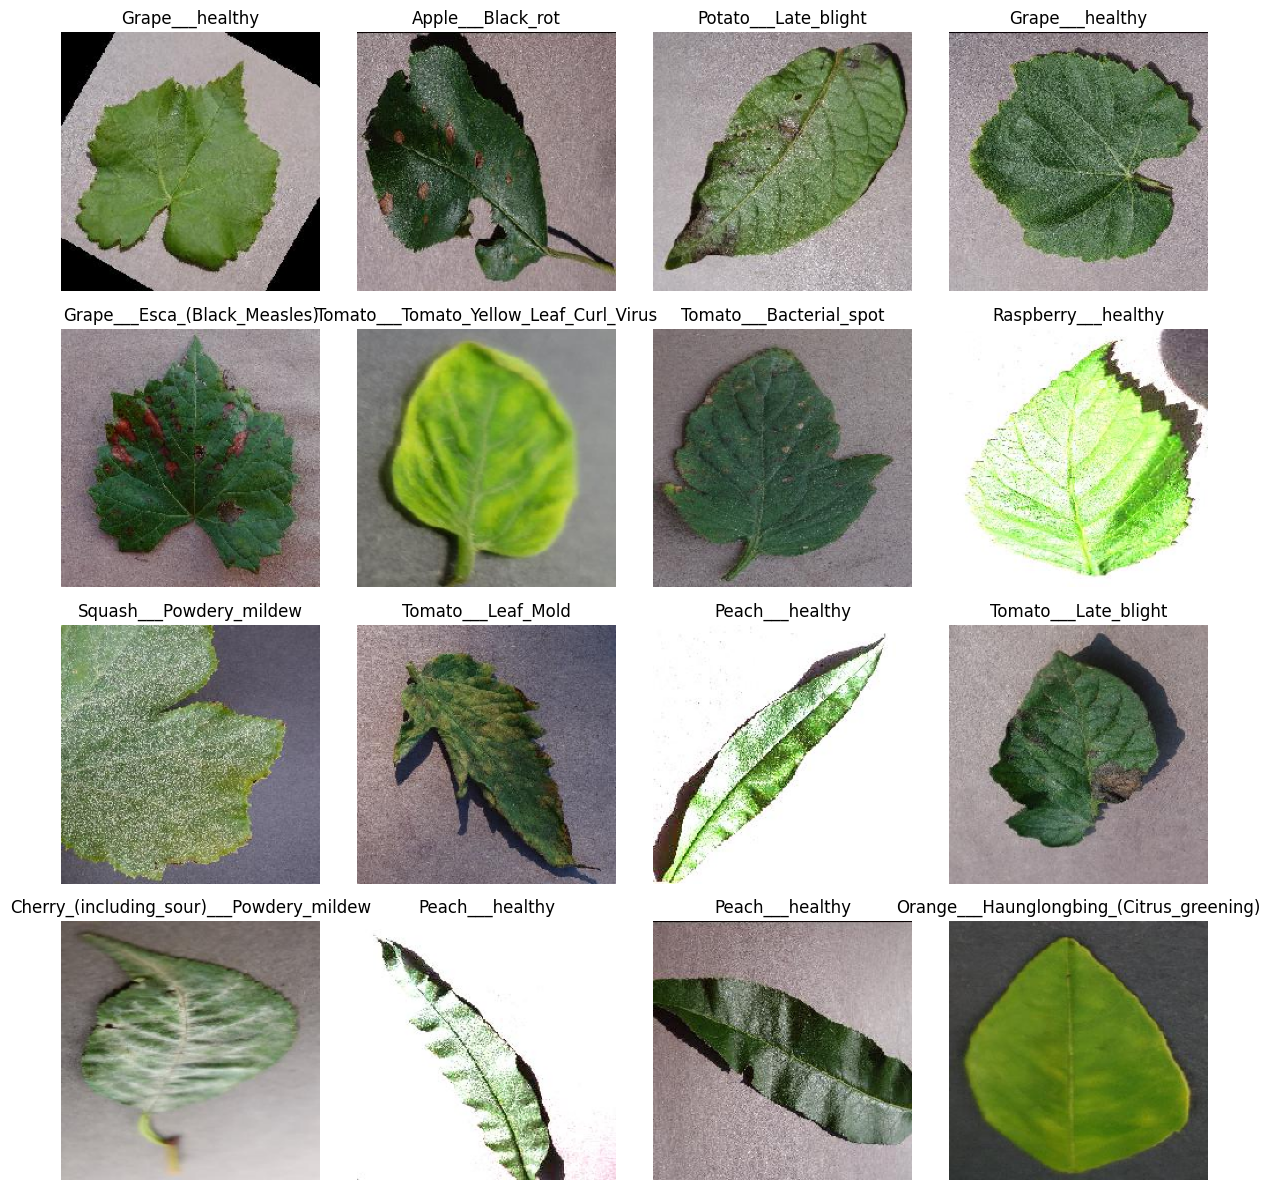

In [9]:
import random
# select a specific batch
images, labels = next(iter(train_data))

# select 16 image by random
indices = random.sample(range(len(images)), 16)
selected_images = images[indices]
selected_labels = labels[indices]

class_names = list(train_data.class_indices.keys())

# plotting
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])  
    plt.axis("off")  

plt.tight_layout()
plt.show()


# ***Modeling***

***Function will be used***

Learning curve function
> * learning curve
> * loss curve

In [20]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


Prediction function
> Compare Truth label (name of image ) with predicted label

In [23]:
def predict_labels_and_display(model_path, test_dir='/kaggle/input/new-plant-diseases-dataset/test/test', image_size=(224, 224)):
    # load the best model
    best_model = load_model(model_path)

    true_labels = []
    predicted_labels = []
    images = []

    for filename in os.listdir(test_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')): 
            # load test images
            img_path = os.path.join(test_dir, filename)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # predict
            prediction = best_model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # extract the label (name of image)
            true_label = filename.split('.')[0]

            # get the prediction class
            class_labels = list(train_data.class_indices.keys())
            predicted_label = class_labels[predicted_class]

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)
            images.append(img)

    # randomly select three images
    selected_indices = random.sample(range(len(images)), 3)

    # show selected images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f'True: {true_labels[idx]}\nPredicted: {predicted_labels[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# ***CNN Model***

In [27]:
# Model Architecture
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(224,224,3), kernel_initializer=GlorotNormal()))
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(64, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(128, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(38, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,446 (1.39 MB)

 Trainable params: 364,550 (1.39 MB)

 Non-trainable params: 896 (3.50 KB)

In [28]:
# train the model
model_checkpoint = ModelCheckpoint('/kaggle/working/cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=10,
                    batch_size=64, 
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.3336 - loss: 2.3769
Epoch 1: val_accuracy improved from -inf to 0.52093, saving model to /kaggle/working/cnn_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 199s 214ms/step - accuracy: 0.3338 - loss: 2.3762 - val_accuracy: 0.5209 - val_loss: 1.6484
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7401 - loss: 0.8658
Epoch 2: val_accuracy improved from 0.52093 to 0.81302, saving model to /kaggle/working/cnn_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 180s 203ms/step - accuracy: 0.7402 - loss: 0.8657 - val_accuracy: 0.8130 - val_loss: 0.5643
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8400 - loss: 0.5133
Epoch 3: val_accuracy improved from 0.81302 to 0.88394, saving model to /kaggle/working/cnn_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 179s 203ms/step - accuracy: 0.8400 - loss: 0.5133 - val_accuracy: 0.8839 - val_loss: 0.3715
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy

In [ ]:
# # save model to use later
# model.save('/kaggle/working/cnn_model.keras')


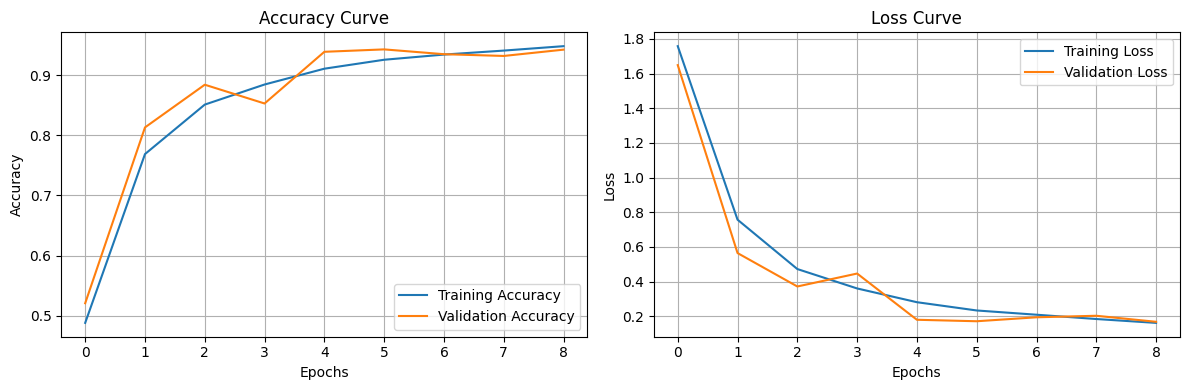

In [29]:
# show learning curves
plot_learning_curves(history)

In [30]:
# showe accuracy on test data (model evaluation)
best_model = load_model('/kaggle/working/cnn_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 111s 400ms/step - accuracy: 0.9461 - loss: 0.1653
Test Loss: 0.1705
Test Accuracy: 0.9432


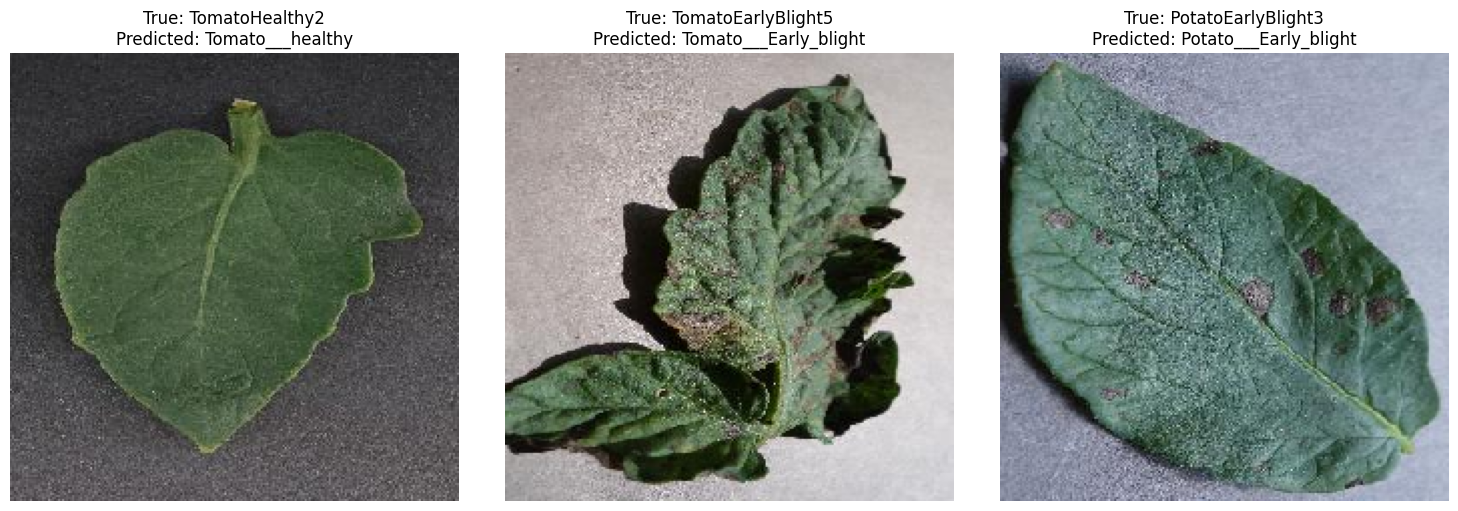

In [60]:
# show random sample of prediction of model on test data
predict_labels_and_display('/kaggle/working/cnn_model.keras')

***Notice that accuracy on CNN model is :***
>* traning accueacy : 0.9233
>* validation accuracy: 0.9426
>* test accuracy : 0.9432

***soo let's try pretrained model***

# ***Vgg_16 Model***

In [16]:
# use VGG16 from Keres
vgg_16 = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))

# iterate through its layers and frezzing them expect the last block (last 5 layers)
for layer in vgg_16.layers[:-5]:
    layer.trainable = False

In [17]:
# take the last layer from VGG16 and link it with my fully connected layer
last_output = vgg_16.output

# take the last layer from VGG16 and link it with my fully connected layer
x = GlobalAveragePooling2D()(last_output)

x = Dense(256, activation='elu', kernel_initializer=GlorotNormal())(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='elu', kernel_initializer=GlorotNormal())(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='elu', kernel_initializer=GlorotNormal())(x)
x = BatchNormalization()(x)


x = Dense(38, activation='softmax')(x)


vgg_model = Model(inputs=vgg_16.input, outputs=x)

vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,930,982 (56.96 MB)

 Trainable params: 7,295,590 (27.83 MB)

 Non-trainable params: 7,635,392 (29.13 MB)

In [18]:
# train the model
model_checkpoint = ModelCheckpoint('/kaggle/working/vgg_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

history =vgg_model.fit(train_data,
                        validation_data=valid_data,
                        epochs=10,  
                        batch_size=64, 
                        callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6260 - loss: 1.3722
Epoch 1: val_accuracy improved from -inf to 0.93392, saving model to /kaggle/working/vgg_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 195s 214ms/step - accuracy: 0.6262 - loss: 1.3714 - val_accuracy: 0.9339 - val_loss: 0.2042
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9439 - loss: 0.1806
Epoch 2: val_accuracy improved from 0.93392 to 0.94126, saving model to /kaggle/working/vgg_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 183s 207ms/step - accuracy: 0.9439 - loss: 0.1806 - val_accuracy: 0.9413 - val_loss: 0.1881
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9676 - loss: 0.1056
Epoch 3: val_accuracy improved from 0.94126 to 0.95222, saving model to /kaggle/working/vgg_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 185s 209ms/step - accuracy: 0.9676 - loss: 0.1056 - val_accuracy: 0.9522 - val_loss: 0.1563
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy

In [ ]:
# # save model to use later
# model.save('/kaggle/working/vgg_model.keras')


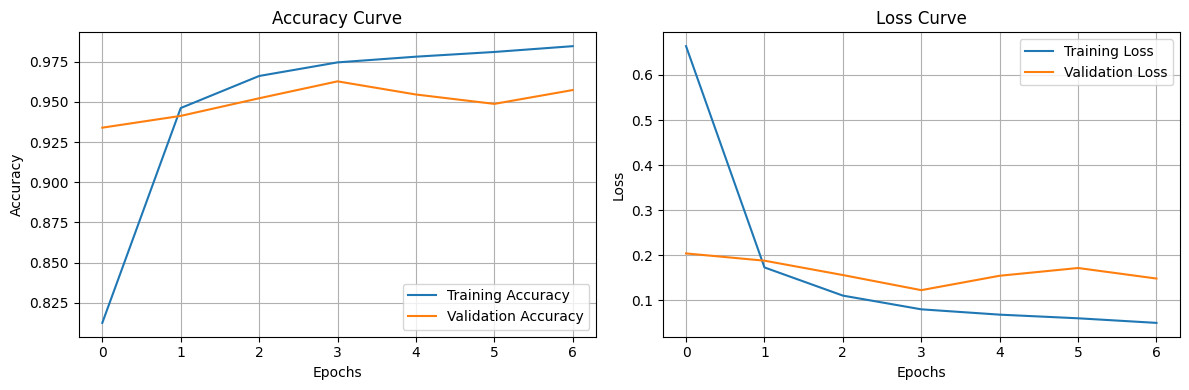

In [21]:
# show learning curves
plot_learning_curves(history)

In [22]:
# showe accuracy on test data
best_model = load_model('/kaggle/working/vgg_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 138s 501ms/step - accuracy: 0.9723 - loss: 0.0865
Test Loss: 0.1124
Test Accuracy: 0.9652


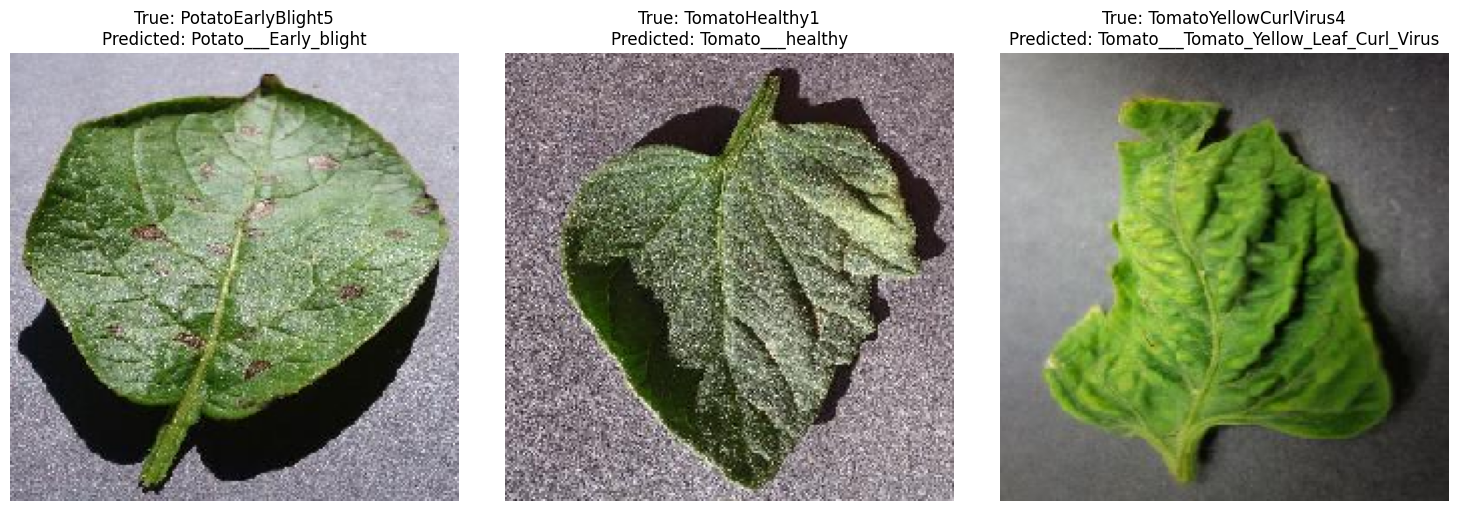

In [28]:
# show random sample of prediction of model on test data
predict_labels_and_display('/kaggle/working/vgg_model.keras')

***Notice that accuracy on VGG_16 model is :***
>* traning accueacy :0.9760
>* validation accuracy: 0.9628
>* test accuracy : 0.9652

***soo let's try another pretrained model***

# ***inception_resnet Model***

In [30]:
inception_resnet = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in inception_resnet.layers:
    layer.trainable = False


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [31]:
last_output = inception_resnet.output

x = GlobalAveragePooling2D()(last_output)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(38, activation='softmax')(x)  

inception_resnet_model = Model(inputs=inception_resnet.input, outputs=x)

inception_resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [35]:
model_checkpoint = ModelCheckpoint('/kaggle/working/inception_resnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001)

history =inception_resnet_model.fit(train_data,
                                    validation_data=valid_data,
                                    epochs=20,  
                                    batch_size=64, 
                                    callbacks=[model_checkpoint, early_stopping, model_ReduceLROnPlateau])

Epoch 1/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7079 - loss: 1.0319
Epoch 1: val_accuracy improved from -inf to 0.85417, saving model to /kaggle/working/inception_resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 254s 249ms/step - accuracy: 0.7080 - loss: 1.0314 - val_accuracy: 0.8542 - val_loss: 0.4424 - learning_rate: 0.0010
Epoch 2/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8826 - loss: 0.3572
Epoch 2: val_accuracy improved from 0.85417 to 0.87938, saving model to /kaggle/working/inception_resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 189s 214ms/step - accuracy: 0.8826 - loss: 0.3572 - val_accuracy: 0.8794 - val_loss: 0.3624 - learning_rate: 0.0010
Epoch 3/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8983 - loss: 0.3037
Epoch 3: val_accuracy did not improve from 0.87938
879/879 ━━━━━━━━━━━━━━━━━━━━ 182s 205ms/step - accuracy: 0.8983 - loss: 0.3037 - val_accuracy: 0.8669 - val_loss: 0.3948 - learning_rate: 0.0010
Epoch 4/20
879/879 

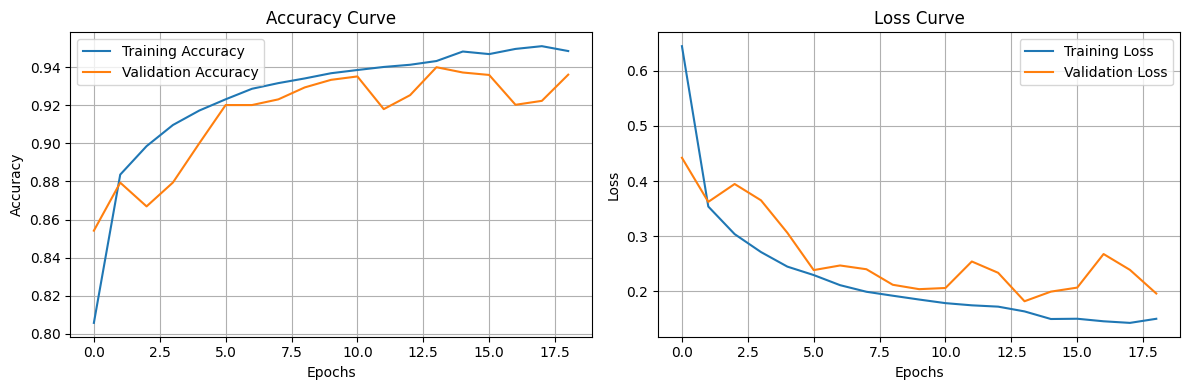

In [36]:
# show learning curves
plot_learning_curves(history)

In [37]:
# showe accuracy on test data
best_model = load_model('/kaggle/working/inception_resnet_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 80s 246ms/step - accuracy: 0.9577 - loss: 0.1289
Test Loss: 0.1566
Test Accuracy: 0.9467


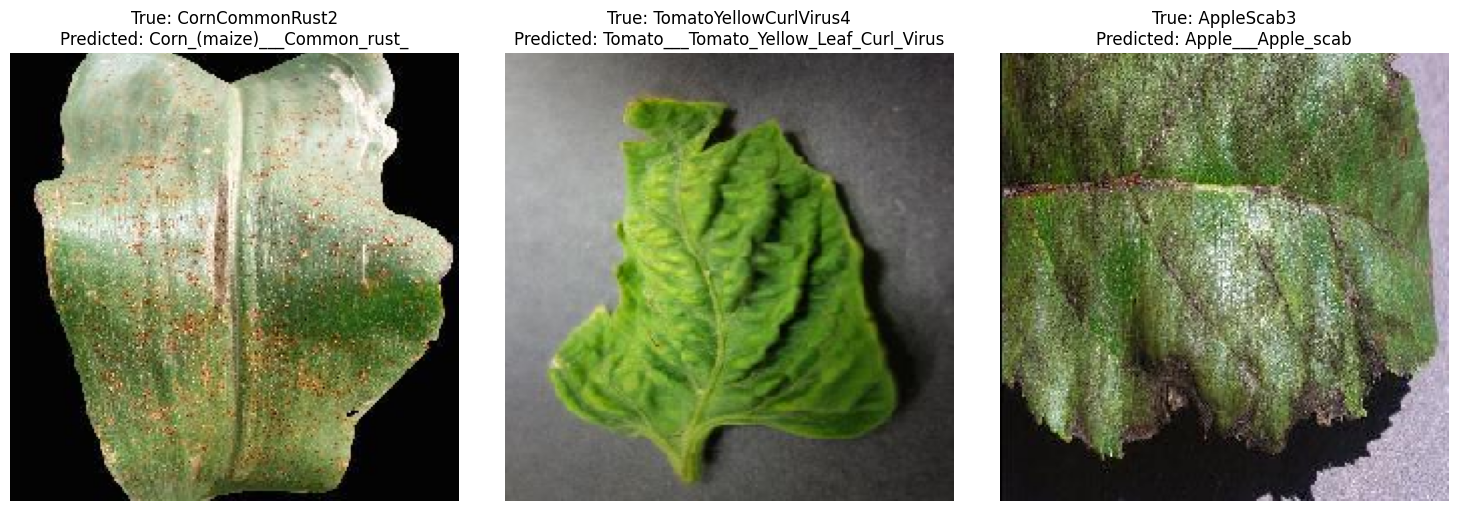

In [38]:
# show random sample of prediction of model on test data
predict_labels_and_display('/kaggle/working/inception_resnet_model.keras')

# ***ResNet50***

In [81]:
# call resnet50 from keres 
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# iterate through its layers and frezzing them
for layer in resnet.layers:
    layer.trainable = False

In [82]:
# Model architecure
last_output = resnet.output

x = GlobalAveragePooling2D()(last_output)

x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

x = Dense(38, activation='softmax')(x)

resnet_model = Model(inputs=resnet.input, outputs=x)

# opt = Adam(learning_rate=0.0001)
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# resnet_model.summary()

In [83]:
model_checkpoint = ModelCheckpoint('/kaggle/working/resnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

history =resnet_model.fit(train_data,
                        validation_data=valid_data,
                        epochs=100,  
                        batch_size=64, 
                        callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.0452 - loss: 3.4979
Epoch 1: val_accuracy improved from -inf to 0.09299, saving model to /kaggle/working/resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 198s 210ms/step - accuracy: 0.0453 - loss: 3.4977 - val_accuracy: 0.0930 - val_loss: 3.1505
Epoch 2/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.1041 - loss: 3.0973
Epoch 2: val_accuracy improved from 0.09299 to 0.20728, saving model to /kaggle/working/resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 173s 195ms/step - accuracy: 0.1041 - loss: 3.0972 - val_accuracy: 0.2073 - val_loss: 2.6838
Epoch 3/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.1997 - loss: 2.7036
Epoch 3: val_accuracy improved from 0.20728 to 0.25612, saving model to /kaggle/working/resnet_model.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 175s 198ms/step - accuracy: 0.1997 - loss: 2.7035 - val_accuracy: 0.2561 - val_loss: 2.5015
Epoch 4/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/st

In [ ]:
# # save model to use later
# model.save('/kaggle/working/vgg_model.keras')


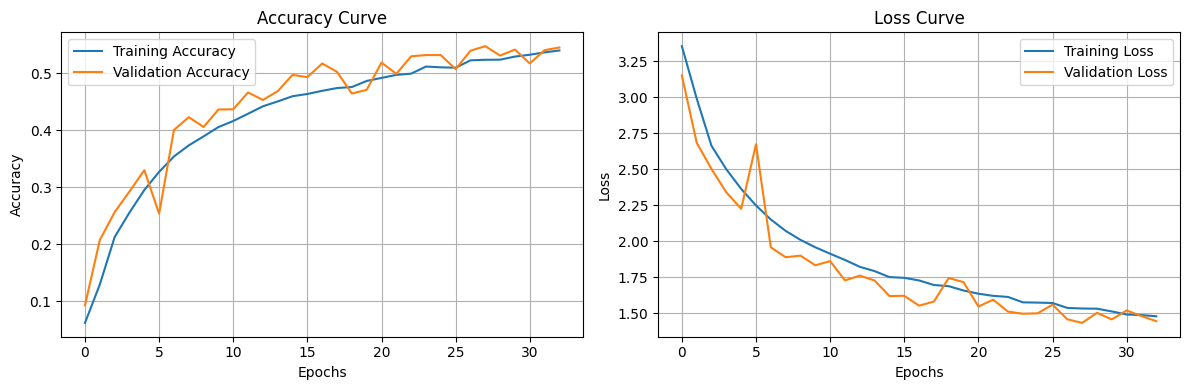

In [84]:
# show learning curves
plot_learning_curves(history)

In [86]:
# showe accuracy on test data
best_model = load_model('/kaggle/working/resnet_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.5146 - loss: 1.5625
Test Loss: 1.4198
Test Accuracy: 0.5520


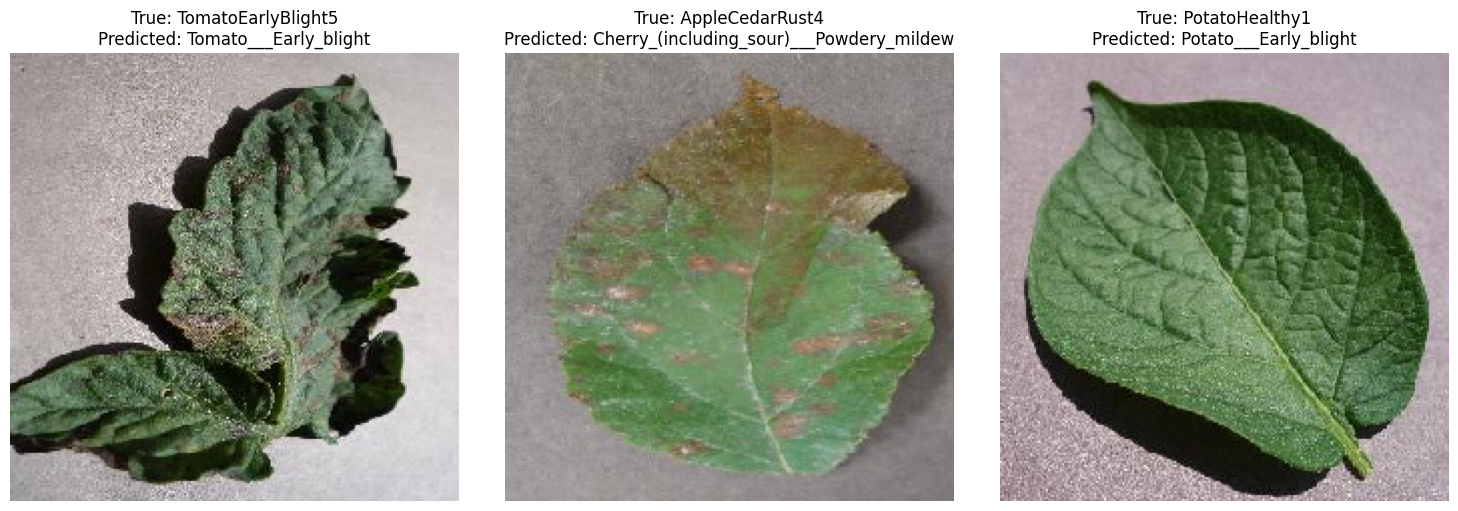

In [88]:
# show random sample of prediction of model on test data
predict_labels_and_display('/kaggle/working/resnet_model.keras')

***Notice that accuracy on ResNet50 model is :***
>* traning accueacy : 0.5208 
>* validation accuracy: 0.5471
>* test accuracy : 0.5520
